# STEP03 BERT fine-tuning

Fine-tuning is the process of further training a pre-trained model on a labeled dataset.[See here](https://huggingface.co/transformers/training.html#)

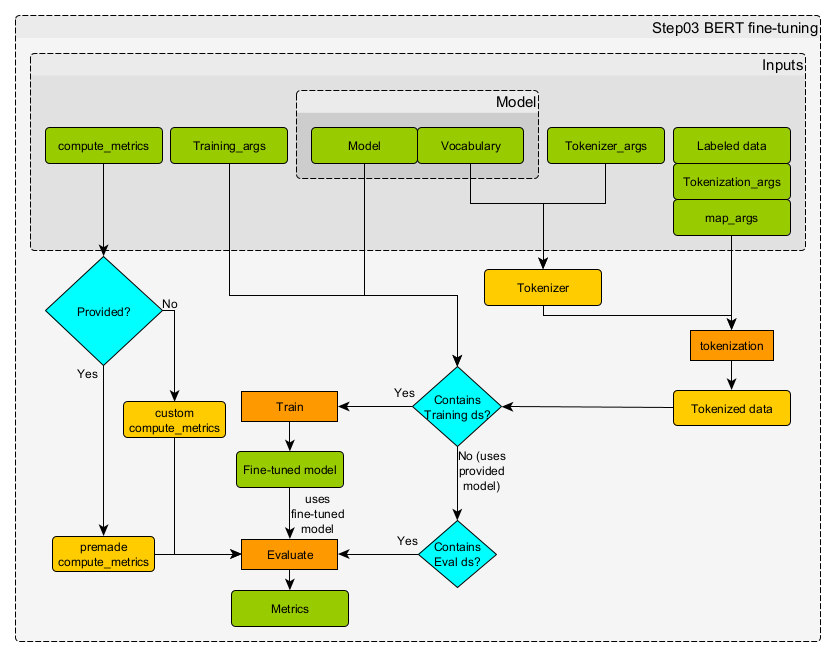

In [1]:
from IPython.display import display, Image
display(Image(filename='images/step03.png'))

# 1. Imports

In [2]:
# Imports
import csv
import numpy as np

from estnltk import Text
from datasets import load_dataset
from pipelines.step03_BERT_fine_tuning import SequenceClassification
from pipelines.step03_BERT_fine_tuning import TokenClassification
from transformers import AutoTokenizer, BertForSequenceClassification, BertForTokenClassification, logging
logging.set_verbosity_warning()

## 2.1 SequenceClassification 


`pipelines.step03_BERT_fine_tuning.SequenceClassification.fine_tune_BERT`
* finetune_BERT - Fine-tunes a bert model on a sequence classification task
* **model_path** *(str)* Path to the pretrained BERT model
* **save_model** *(bool, default=True)* To save a model or not
* **dataset_args** *(dict, default=None)* A dictionary that can contain:
    * **train_data_paths** *(str or list of str, default="")* path or paths to files, that contain training data
    * **eval_data_paths** *(str or list of str, default="")* path or paths to files, that contain evaluation data
    * **class_to_index** *(dict, default=None) a dictionary that maps classes/labels to indices
    * **text_col** *(str, default="text")* The column name in which the sentences are
    * **y_col** *(str, default="y")* The column name of the response variable
    * **skiprows** *(int, default=0)* skips described rows in the data files
    * **delimiter** *(str, default="\t")* the delimiter in the data files
* [**map_args**](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) (dict, default=None)]
* [**tokenizer_args**](https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast)(dict, default=None) 
* [**tokenization_args**](https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.__call__) (dict, default=None) 
* [**training_args**](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) (dict, default=None), Arguments used in training. If None, the default training args will be used (except do_train will be True and output_dir will be the model path). 
* **compute_metrics** (function, default=None), Function that calculates metrics. If None then accuracy, precision, recall and f1 scores are calculated
* [**callbacks**](https://huggingface.co/transformers/main_classes/callback.html) (list of functions, default=None) A list of callbacks to customize the training loop)
* **optimizers** (A tuple containing the optimizer and the scheduler, default = (None, None)) Will default to an instance of AdamW on your model and a scheduler given by get_linear_schedule_with_warmup() controlled by args.


* **return** If eval_dataset is provided, then it returns the results of the evaluation. Otherwise None.

The dataset must have at least 2 columns, where one contains individual sentences and another their labels. You can use the `text_col` and `y_col` arguments in the `dataset_args` to specify which column contains the sentences and which contains the labels. The training and eval datasets must be given as separate files by using the `train_data_paths` and `eval_data_paths` arguments. Either can be provided as a string or list of strings.

[Link to Huggingface Sequence model description](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification)

### 2.1.1 Dataset 

In [3]:
# Creating an example dataset
# Lets say we want to classify sentences that contain dates

ds = load_dataset("csv", data_files={'train': 'data/corp_res_clean_r_events_par.tsv'}, delimiter="\t")

In [4]:
# displaying the text
ds['train']['text'][3]

'Veebruarikuus sai ühtäkki meediastaariks sümpaatne valgenäoline utt Dolly .\nTa vaatas meile vastu pea kõikide tähtsamate väljaannete lehekülgedelt ning temaga seostati pöördelisi , lausa meie tsivilisatsiooni alustugesid kõigutavaid tulevikuväljavaateid .\nPöördusin Helsingi ülikooli Biotehnoloogia Instituudi direktori akadeemik Mart Saarma poole , et kuulda , mida kloonitud lamba sünd tähendab teadusele ja meile kõigile .\nEelkõige on tegu äärmiselt olulise teadussaavutusega , mille sisu mõistmisele aitab kaasa üks väike kõrvalepõige ajalukku .\nJuba <DATE> .\naastal tegi inglane John Gurdon kloonimiskatseid , kuid mitte imetajate , vaid konnadega .\nTa võttis kannuskonna keharaku tuuma ja siirdas selle konna munarakku .\nNagu teame , on konna munarakud , ( konnakudu ) väga suured .\nParaku ei õnnestunud aga Gurdonil täiskasvanud konna saada , munarakk arenes vaid kulleseni .\n<DATE> .\naastal avaldas sveitsi teadlane Karl Ilmensee koos ühe ameerika kolleegiga artikli väitega , et t

In [5]:
out_path = "data/step03_seq_class_horisont_example.tsv"
with open(out_path, 'w', newline='', encoding='utf-8') as out_file:
    writer = csv.writer(out_file, delimiter="\t")
    # saving the column names
    writer.writerow(["text", "y"])
    for document in ds['train']['text']:
        for sentence in document.split("\n"):
            # saving sentences and labels to a file
            label = 1 if "<DATE>" in sentence else 0
            writer.writerow([sentence, label])

##### Looking at the data

In [6]:
ds = load_dataset("csv", data_files={'train': out_path}, delimiter="\t")
print(ds['train']['text'][:5])
print(ds['train']['y'][:5])

Dataset csv downloaded and prepared to C:\Users\Meelis\.cache\huggingface\datasets\csv\default-30b459a374a1b78e\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.
['MARIA TEIVERLAUR <br> Mina olen veel noor … <br> MARIA TEIVERLAUR ( <DATE> ) on meditsiinipsühholoog , Jämejala Psühhiaatriahaigla psühholoogia kabineti juhataja .', 'Viljandi Kultuurikolledzi õppejõud .', 'Pedagoogikakandidaat aastast <DATE> .', 'Teie käest küsitakse , kui vana Te olete .', 'Tundub , et sellele pärimisele on lihtne vastata .']
[1, 0, 1, 0, 0]


### 2.1.2 Fine-tuning

In [7]:
model_path = "data/test_model_step03_seq_class"
dataset_args = {
            "train_data_paths": out_path,
            "eval_data_paths": out_path, # testing on training data for now
            "text_col": "text",
            "y_col": "y",
            "skiprows": 0,
        }
map_args = {
    # make sure that tokenization creates vectors of equal length when you use
    #"batched": True (also set "max_length": <a number>, "padding": "max_length" in tokenization args)
    "batched": True, 
}

tokenizer_args = {
    "lowercase": False,
    # also providing the additinal special tokens, because the tokenizer does not know about these yet
}
tokenization_args = {
    "max_length": 128,
    "padding": "max_length",
    "truncation": True
}
training_args = {
    "output_dir": model_path,
    "num_train_epochs": 1,
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8
}

# fine-tuning the model
res = SequenceClassification.finetune_BERT("tartuNLP/EstBERT", True, dataset_args, map_args, tokenizer_args, tokenization_args, training_args)
print(res)

Dataset csv downloaded and prepared to C:\Users\Meelis\.cache\huggingface\datasets\csv\default-311a6533eefbe724\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


Some weights of the model checkpoint at tartuNLP/EstBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tartuNLP/EstBERT and are new

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to data/test_model_step03_seq_class
Configuration saved in data/test_model_step03_seq_class\config.json
Model weights saved in data/test_model_step03_seq_class\pytorch_model.bin
tokenizer config file saved in data/test_model_step03_seq_class\tokenizer_config.json
Special tokens file saved in data/test_model_step03_seq_class\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2021
  Batch size = 8


{'eval_loss': 6.639515049755573e-05, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 12.243, 'eval_samples_per_second': 165.074, 'eval_steps_per_second': 20.665, 'epoch': 1.0}


### 2.1.3 Manual Testing

In [8]:
# test

# loading the tokenizer and the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_args)
model = BertForSequenceClassification.from_pretrained(model_path)

def predict(sentence):
    # tokenizing
    inputs = tokenizer(sentence, return_tensors="pt", **tokenization_args)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = model.config.id2label[np.argmax(logits.detach().numpy())]
    print(f"predicts label: {predicted_label}")

# providing it a sentence
predict("selles lauses on palju kuupäevi ja päevi")
# shouldn't be 1, but it is, because tokenizer tokenizes DATE as < DATE >
predict("selles lauses on palju kuupäevi ja päevi DATE") 
predict("selles lauses on palju kuupäevi ja päevi <DATE>")



Didn't find file data/test_model_step03_seq_class\added_tokens.json. We won't load it.
loading file data/test_model_step03_seq_class\vocab.txt
loading file data/test_model_step03_seq_class\tokenizer.json
loading file None
loading file data/test_model_step03_seq_class\special_tokens_map.json
loading file data/test_model_step03_seq_class\tokenizer_config.json
loading configuration file data/test_model_step03_seq_class\config.json
Model config BertConfig {
  "_name_or_path": "tartuNLP/EstBERT",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attent

predicts label: 0
predicts label: 1
predicts label: 1


## 2.2 Token Classification


`pipelines.step03_BERT_fine_tuning.TokenClassification.finetune_BERT`
* finetune_BERT - Fine-tunes a bert model on a token classification task
* **model_path** *(str)* Path to the pretrained BERT model
* **save_model** *(bool, default=True)* To save a model or not
* **dataset_args** *(dict, default=None)* A dictionary that can contain:
    * **train_data_paths** *(str or list of str, default="")* path or paths to files, that contain training data
    * **eval_data_paths** *(str or list of str, default="")* path or paths to files, that contain evaluation data
    * **class_to_index** *(dict, default=None) a dictionary that maps classes/labels to indices
    * **label_all_subword_units** *(bool, default=False)* if set to True, the function labels all subword units, if False, then only the first 
    * **has_header_col** *(bool, default=True)* Set to True if the column names are in the dataset. If False then set `text_col ` and `y_col` as integers!
    * **text_col** *(str, default="text")* The column name or index in which the sentences are
    * **y_col** *(str, default="y")* The column name or index of the response variable
    * **skiprows** *(int, default=0)* skips described rows in the data files
    * **delimiter** *(str, default="\t")* the delimiter in the data files
* [**map_args**](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) (dict, default=None)]
* [**tokenizer_args**](https://huggingface.co/transformers/model_doc/bert.html#berttokenizerfast)(dict, default=None) 
* [**tokenization_args**](https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.__call__) (dict, default=None) 
* [**training_args**](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) (dict, default=None), Arguments used in training. If None, the default training args will be used (except do_train will be True and output_dir will be the model path). 
* **compute_metrics** (function, default=None), Function that calculates metrics. If None then accuracy, precision, recall and f1 scores are calculated
* [**callbacks**](https://huggingface.co/transformers/main_classes/callback.html) (list of functions, default=None) A list of callbacks to customize the training loop)
* **optimizers** (A tuple containing the optimizer and the scheduler, default = (None, None)) Will default to an instance of AdamW on your model and a scheduler given by get_linear_schedule_with_warmup() controlled by args.


* **return** If eval_dataset is provided, then it returns the results of the evaluation. Otherwise None.


[Link to Huggingface Token Classification model description](https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification)

### 2.2.1 Dataset

The Token classification function in this package, makes use of the [Beginning-Inside–Outside (BIO)](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) tags structure. It doesn't actually matter what label names you choose for your tokens. However there must be an empty line between sentences.

Here is an example of a labelled sentence:

* Ma (B_P)
* ei (B_V)
* hooli (O_V)
* juveelidest (B_S)
* . (B_Z)
* Mulle (B_P)
* meeldivad (B_V)
* lilled (B_S)
* . (B_Z)

In [9]:
# Lets create a dataset for token classification

# files to read/write
in_path = 'data/corp_res_no_clean.tsv'
data_path = "data/step03_tok_class_horisont_example.tsv"

#
def extractPOS(sentence):
    t = Text(sentence)
    # tagging the object
    t.tag_layer(['words', 'sentences', 'morph_analysis'])
    t_pos = t.morph_analysis['text','partofspeech']
    new_sentence = []
    new_label = []
    for i, cur_lp  in enumerate(t_pos):
        last_p = None
        nxt_p = None
        if i != 0:
            last_p = t_pos[i-1][0][1]
        if i != len(t_pos)-1:
            nxt_p = t_pos[i+1][0][1]
        cur_p = cur_lp[0][1]
        
        new_sentence.append(cur_lp[0][0]) 
        # Outside
        if cur_p == last_p and cur_p != nxt_p:
            new_label.append("O_" + cur_p)
        # Inside
        elif cur_p == last_p and cur_p == nxt_p:
            new_label.append("I_" + cur_p)
        # Beginning
        else:
            new_label.append("B_" + cur_p)
    return new_sentence, new_label
        
    
    
# loading the initial texts
ds = load_dataset("csv", data_files={'train': in_path}, delimiter="\t")

# lets use the morph_analysis from the estnltk library to help tag the tokens
with open(data_path, 'w', newline='', encoding='utf-8') as out_file:
    writer = csv.writer(out_file, delimiter="\t")
    # saving the column names
    writer.writerow(["text", "y"])
    for document in ds['train']['text']:
        for sentence in document.split("\n"):
            # here we can look at the sentences one at a time
            # converting sentence into a estNLTK Text object
            sent, labs = extractPOS(sentence)
            for s, l in zip(sent, labs):
                writer.writerow([s, l])
            writer.writerow([""])
            
            

In [10]:
# looking at the file
n = 5
with open(data_path, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter="\t")
    for i, row in enumerate(reader):
        print(row)
        if i == n:
            break

['text', 'y']
['MARIA', 'B_H']
['TEIVERLAURMina', 'B_Y']
['olen', 'B_V']
['veel', 'B_D']
['noor', 'B_A']


### 2.2.2 Fine-tuning

In [11]:
# Training a token classificator

model_path = "tartuNLP/EstBERT"
output_dir = "/data/test_model_step03_token_classification"
input_files = data_path

dataset_args = {
    "train_data_paths": input_files,
    "eval_data_paths": input_files,
    "text_col": "text",
    "y_col": "y",
    "skiprows": 0,
    "delimiter": "\t"
}
map_args = {
    "batched": True,
}
tokenizer_args = {
    "lowercase": False,
}
tokenization_args = {
    "max_length": 128,
    "padding": "max_length",
    "truncation": True
}
training_args = {
    "output_dir": output_dir,
    "overwrite_output_dir": True,
    "num_train_epochs": 1,
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8
}

# First fine-tuning the model
res = TokenClassification.finetune_BERT(model_path, True, dataset_args, map_args, tokenizer_args, tokenization_args,
                                  training_args)


loading configuration file https://huggingface.co/tartuNLP/EstBERT/resolve/main/config.json from cache at C:\Users\Meelis/.cache\huggingface\transformers\ec9199513abdb95d60f6cf36b703a7b5db97aaf8aacaaf68beca4e599cdcab69.9c82c393b56cf2111aaf41ee1036d95e1684783f0d3d844fa1245b0e592bac1a
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file https://huggingface.co/tartuNLP/EstBERT/resolve

loading configuration file https://huggingface.co/tartuNLP/EstBERT/resolve/main/config.json from cache at C:\Users\Meelis/.cache\huggingface\transformers\ec9199513abdb95d60f6cf36b703a7b5db97aaf8aacaaf68beca4e599cdcab69.9c82c393b56cf2111aaf41ee1036d95e1684783f0d3d844fa1245b0e592bac1a
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LA

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to /data/test_model_step03_token_classification
Configuration saved in /data/test_model_step03_token_classification\config.json
Model weights saved in /data/test_model_step03_token_classification\pytorch_model.bin
tokenizer config file saved in /data/test_model_step03_token_classification\tokenizer_config.json
Special tokens file saved in /data/test_model_step03_token_classification\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1859
  Batch size = 8


In [12]:
print(res)

{'eval_loss': 0.4451758563518524, 'eval_precision': 0.856477205756332, 'eval_recall': 0.8781424351821464, 'eval_f1': 0.856239247973125, 'eval_accuracy': 0.8781424351821464, 'eval_runtime': 12.128, 'eval_samples_per_second': 153.282, 'eval_steps_per_second': 19.212, 'epoch': 1.0}


### 2.2.3 Manual testing

In [13]:
model_path = "/data/test_model_step03_token_classification"

# loading the tokenizer and the fine-tuned model

tokenizer = AutoTokenizer.from_pretrained(model_path, **tokenizer_args)
model = BertForTokenClassification.from_pretrained(model_path)
tokenization_args['is_split_into_words'] = True

def predict(sentence):
    # tokenizing
    tokens = sentence.split(" ")
    inputs = tokenizer([tokens], return_tensors="pt", **tokenization_args)
    outputs = model(**inputs)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), -1)
    predicted_label = [model.config.id2label[p] for p in preds[0]]
    
    print("predicts labels:")
    for t,lab in zip(inputs['input_ids'][0], predicted_label[:len(inputs['input_ids'][0])]):
        if t == 0:
            break
        print(tokenizer.decode(t), lab)
    

predict("Kirjuta siia oma lause, mida tahad katsetada.")

Didn't find file /data/test_model_step03_token_classification\added_tokens.json. We won't load it.
loading file /data/test_model_step03_token_classification\vocab.txt
loading file /data/test_model_step03_token_classification\tokenizer.json
loading file None
loading file /data/test_model_step03_token_classification\special_tokens_map.json
loading file /data/test_model_step03_token_classification\tokenizer_config.json
loading configuration file /data/test_model_step03_token_classification\config.json
Model config BertConfig {
  "_name_or_path": "tartuNLP/EstBERT",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B_A",
    "1": "B_C",
    "2": "B_D",
    "3": "B_G",
    "4": "B_H",
    "5": "B_I",
    "6": "B_J",
    "7": "B_K",
    "8": "B_N",
    "9": "B_O",
   

predicts labels:
[CLS] B_Z
kirjuta B_V
siia B_D
oma B_P
lause B_S
, B_Z
mida B_P
tahad B_V
katsetada B_V
. B_Z
[SEP] B_V
